## Biomass Burning Aerosol with Cloud Interactions

Welcome to the **Biomass Burning Aerosol with Cloud Interactions** notebook, your step‑by‑step guide to setting up and running multi‑component aerosol simulations using **Particula**. Even if you’re new to aerosol modeling or cloud microphysics, this notebook will walk you through:

1. **What This Notebook Is About**  
   This notebook demonstrates how to set up and run a multi‑component particle resolved aerosol simulation using Particula. The example focuses on biomass burning aerosols, which are a mixture of soot, organics, and water. The simulation will explore how these aerosols behave under cloud conditions, including their activation into cloud droplets and subsequent evolution through condensation and coagulation processes.

2. **Why It Matters**  
   Biomass burning aerosols (soot + organics + water) play a critical role in cloud formation, climate forcing, and air quality. Understanding how these mixed particles activate into cloud droplets and evolve through condensation and coagulation helps bridge experiments and models.

3. **What You’ll Learn**  
   - Configuring species properties (molar masses, densities, hygroscopicity)  
   - Building gas‑phase and particle‑phase objects  
   - Running isothermal condensation and four coagulation scenarios:  
     - **Condensation Only**  
     - **Condensation + Brownian Coagulation**  
     - **Condensation + Brownian + Sedimentation Coagulation**  
     - **Condensation + Brownian + Turbulent DNS Coagulation**  
   - Visualizing size distributions, number concentrations, and mass fractions  
   - Comparing saturation ratios across processes  

> No prior experience with Particula is required—simply follow the markdown cells and code examples to explore how mixed‐phase aerosols behave under cloud‐like conditions.

## Imports and Plot Configuration

In this section we:

1. **Import core libraries**  
   - `copy` to create deep copies of objects
   - `matplotlib.pyplot` for plotting  
   - `numpy` for numerical operations  
   - `particula` (aliased as `par`) as our aerosol simulation framework  
   - `tqdm` for progress bars in loops  

2. **Configure global plot style**  
   - Use the **Tailwind** color palette from Particula’s utilities  
   - Set a neutral base color (`gray-600`) for text, axes, and ticks  
   - Establish a default figure size and font size  
   - Ensure fonts are embedded correctly in PDF/PS outputs  

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import particula as par
from tqdm import tqdm

# plot settings
TAILWIND = par.util.colors.TAILWIND
base_color = TAILWIND["gray"]["600"]
plt.rcParams.update(
    {
        "text.color": base_color,
        "axes.labelcolor": base_color,
        "figure.figsize": (5, 4),
        "font.size": 14,
        "axes.edgecolor": base_color,
        "axes.labelcolor": base_color,
        "xtick.color": base_color,
        "ytick.color": base_color,
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
    }
)

## Setup for Biomass‐Burning Organic Aerosol (BBOA) in a Cloud Environment

In this section we configure a particle‑resolved BBOA simulation under cloud‑like conditions:

1. **Reproducibility**  
   – Fix the random seed (`np.random.seed(100)`) for consistent sampling across runs.

2. **Species Properties**  
   – Molar masses (organics, soot, water)  
   – Densities (kg m⁻³)  
   – Hygroscopicity parameters (κ values)

3. **Simulation Parameters**  
   – `number_of_samples` (particles)  
   – Simulation volume (`1e‑6 m⁻³`)  
   – Initial water activity (`1.02`) and temperature (`298.15 K`)

4. **Vapor‑Pressure Strategies**  
   – Constant builder for organics and soot  
   – Buck equation for water vapor

5. **Gas‑Phase Composition**  
   – Build a `GasSpecies` object with condensable vapors and set concentrations  
   – Assemble into an `Atmosphere` with temperature and pressure

6. **Particle Size Distributions**  
   – Draw lognormal samples for organics and soot modes  
   – Initialize water mass as the sum of organics and soot volumes (so water mass = 0 at start)

7. **Mass Speciation & Parameterization**  
   – Stack species masses into an (N×3) array  
   – Define a κ‑Köhler activity strategy and a surface‑volume strategy

8. **Particle‑Resolved Representation**  
   – Use `ResolvedParticleMassRepresentationBuilder` to combine mass, density, charge (0), and volume

9. **Aerosol Object & Initial Visualization**  
   – Instantiate `par.Aerosol(atmosphere, particles)`  
   – Plot a histogram of log₁₀ particle radii to verify the initial distribution

> **Pro tip:** For fast prototyping, begin with `5 000 – 10 000` particles. Once your setup is validated, increase `number_of_samples`, simulation length, or time resolution.


Gas mixture at 298.15 K and 101325.0 Pa consisting of ["['organics' 'soot' 'water']"]
Particle Representation:
	Strategy: ParticleResolvedSpeciatedMass
	Activity: ActivityKappaParameter
	Surface: SurfaceStrategyVolume
	Mass Concentration: 3.423e-07 [kg/m^3]
	Number Concentration: 1.000e+10 [#/m^3]


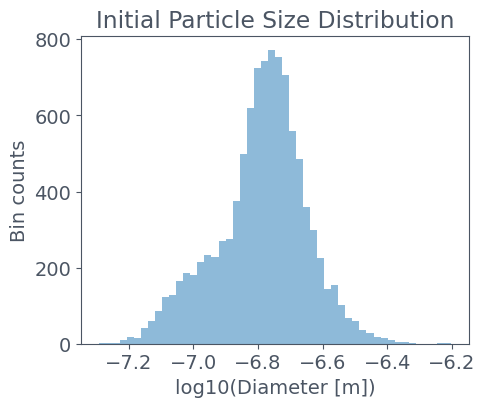

In [2]:
# Reproducibility
np.random.seed(100)

# 1a. Species properties
molar_mass_organics = 250e-3  # kg/mol
molar_mass_soot = 1000e-3  # kg/mol
molar_mass_water = 18.01528e-3  # kg/mol

density_organics = 1400.0  # kg/m^3
density_soot = 1800.0
density_water = 1000.0

kappa_organics = 0.15
kappa_soot = 0.01
kappa_water = 0.01

number_of_samples = 10_000  # number of particles to sample
simulation_volume = 1e-6  # 1/m^3
water_activity = 1.02  # initial water activity
temperature = 298.15

# Vapor pressure strategies
vapor_organics = (
    par.gas.ConstantBuilder().set_vapor_pressure(2e-12, "Pa").build()
)
vapor_soot = par.gas.ConstantBuilder().set_vapor_pressure(1e-30, "Pa").build()
vapor_water = par.gas.WaterBuckBuilder().build()

# Gas species
water_sat = vapor_water.saturation_concentration(molar_mass_water, temperature)
water_conc = water_sat * water_activity

gas_species = (
    par.gas.GasSpeciesBuilder()
    .set_name(np.array(["organics", "soot", "water"]))
    .set_molar_mass(
        np.array([molar_mass_organics, molar_mass_soot, molar_mass_water]),
        "kg/mol",
    )
    .set_condensable(True)
    .set_vapor_pressure_strategy([vapor_organics, vapor_soot, vapor_water])
    .set_concentration(np.array([1e-12, 1e-12, water_conc]), "kg/m^3")
    .build()
)

atmosphere = (
    par.gas.AtmosphereBuilder()
    .add_species(gas_species)
    .set_temperature(temperature, "K")
    .set_pressure(1, "atm")
    .build()
)

# Particle distributions
radii_organics = par.particles.get_lognormal_sample_distribution(
    mode=np.array([30e-9, 110e-9]),
    geometric_standard_deviation=np.array([1.3, 1.2]),
    number_of_particles=np.array([0.2, 0.6]),
    number_of_samples=number_of_samples,
)
radii_soot = par.particles.get_lognormal_sample_distribution(
    mode=np.array([75e-9, 120e-9]),
    geometric_standard_deviation=np.array([1.3, 1.4]),
    number_of_particles=np.array([2, 1]),
    number_of_samples=number_of_samples,
)

mass_organic = 4 / 3 * np.pi * (radii_organics**3) * density_organics
mass_soot = 4 / 3 * np.pi * (radii_soot**3) * density_soot
mass_water = mass_organic + mass_soot

mass_speciation = np.column_stack((mass_organic, mass_soot, mass_water))

# Activity strategy
activity_strategy = (
    par.particles.ActivityKappaParameterBuilder()
    .set_density([density_organics, density_soot, density_water], "kg/m^3")
    .set_molar_mass(
        [molar_mass_organics, molar_mass_soot, molar_mass_water], "kg/mol"
    )
    .set_kappa(np.array([kappa_organics, kappa_soot, kappa_water]))
    .set_water_index(2)
    .build()
)

surface_strategy = par.particles.SurfaceStrategyVolume()

# Create Particula particle object
resolved_masses = (
    par.particles.ResolvedParticleMassRepresentationBuilder()
    .set_distribution_strategy(par.particles.ParticleResolvedSpeciatedMass())
    .set_activity_strategy(activity_strategy)
    .set_surface_strategy(surface_strategy)
    .set_mass(mass_speciation, "kg")
    .set_density(
        np.array([density_organics, density_soot, density_water]), "kg/m^3"
    )
    .set_charge(0)  # no charge on particles
    .set_volume(simulation_volume, "m^3")
    .build()
)

# Create Aerosol object
aerosol = par.Aerosol(atmosphere=atmosphere, particles=resolved_masses)
print(aerosol)


# Plot initial size distribution
fig, ax = plt.subplots()
ax.hist(
    np.log10(resolved_masses.get_radius()), bins=50, density=False, alpha=0.5
)
ax.set_xlabel("log10(Diameter [m])")
ax.set_ylabel("Bin counts")
ax.set_title("Initial Particle Size Distribution");

## Simulation: Isothermal Condensation

In this section we run an isothermal condensation on our activated aerosol, track how the size distribution evolves over time, and visualize the result as a contour of number concentration.

1. **Define the Condensation Process**  
   We use `CondensationIsothermal` with specified molar masses, diffusion coefficient, and accommodation coefficient, wrapped by `MassCondensation`.

2. **Pre‑activation Step**  
   A small “spin‑up” condensation to initialize vapors on the dry aerosol.

3. **Time Loop**  
   - Divide the total simulation time into equal “sub‑step” chunks.  
   - At each time step, execute the condensation process and record the particle radii histogram.

4. **Post‑processing & Plotting**  
   - Convert raw counts to number concentration (# m⁻³).  
   - Build a 2D mesh of time vs. radius and plot `log10` of concentration on a log‑radius axis.

> **Pro tip:** If the water saturation ratio is much lower than 1, in a cloud environment, the time step may be too large. Consider reducing the time step to ensure accurate results.

Condensing: 100%|██████████| 600/600 [00:44<00:00, 13.36it/s]


Gas mixture at 298.15 K and 101325.0 Pa consisting of ["['organics' 'soot' 'water']"]
Particle Representation:
	Strategy: ParticleResolvedSpeciatedMass
	Activity: ActivityKappaParameter
	Surface: SurfaceStrategyVolume
	Mass Concentration: 4.613e-04 [kg/m^3]
	Number Concentration: 1.000e+10 [#/m^3]
Final water saturation ratio: 0.9999831326202219


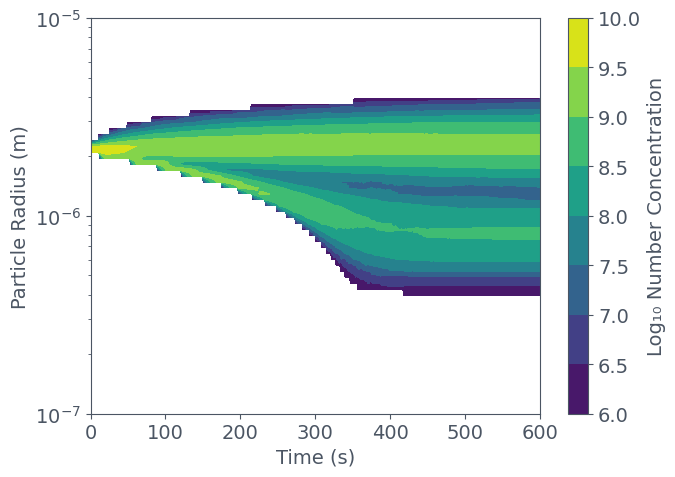

In [3]:
# Condensation process setup
condensation_strategy = par.dynamics.CondensationIsothermal(
    molar_mass=np.array(
        [molar_mass_organics, molar_mass_soot, molar_mass_water]
    ),
    diffusion_coefficient=2e-5,
    accommodation_coefficient=1,
)
condensation_process = par.dynamics.MassCondensation(condensation_strategy)

# Copy aerosol and define time bins
aerosol_activated = copy.deepcopy(aerosol)
time_step = 600  # total simulation time in seconds
total_steps = 5_000  # total sub‑steps for finer resolution
time = np.linspace(0, time_step, time_step)  # 1‑second resolution
bins_lognormal = np.logspace(-8, -2, 200)  # radius bins from 10⁻⁸ to 10⁻² m
distribution_counts = np.zeros((len(time), len(bins_lognormal) - 1))

# Pre‑activation “spin‑up”
aerosol_activated = condensation_process.execute(
    aerosol=aerosol_activated, time_step=0.01, sub_steps=3_000
)

# Main simulation loop
sub_steps_per_sec = int(total_steps / time_step)
for i, t in enumerate(tqdm(time, desc="Condensing")):
    if i > 0:
        aerosol_activated = condensation_process.execute(
            aerosol=aerosol_activated, time_step=1, sub_steps=sub_steps_per_sec
        )
    # Record the size distribution at this time
    distribution_counts[i, :], edges = np.histogram(
        aerosol_activated.particles.get_radius(clone=True), bins=bins_lognormal
    )

# Print final state and water saturation
print(aerosol_activated)
print(
    "Final water saturation ratio:",
    aerosol_activated.atmosphere.species[0].get_saturation_ratio(298.15)[-1],
)

# Convert counts → number concentration (#/m³)
concentrations = distribution_counts / simulation_volume

# Contour plot of log10(number concentration)
fig, ax = plt.subplots(figsize=(7, 5))
X, Y = np.meshgrid(time, edges[:-1])
log_conc = np.log10(
    concentrations,
    where=concentrations > 0,
    out=np.full_like(concentrations, np.nan),
)
cont = ax.contourf(X, Y, log_conc.T)

ax.set_yscale("log")
ax.set_ylim(1e-7, 1e-5)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Particle Radius (m)")
fig.colorbar(cont, label="Log₁₀ Number Concentration")
plt.tight_layout()
plt.show()

## Four Coagulation + Condensation Scenarios

We apply each coagulation strategy in sequence with isothermal condensation to see how different particle interactions impact the final water saturation ratio:

1. **Condensation Only**  
   No coagulation—particles grow only by condensation.

2. **Brownian Coagulation**  
   Particle‐resolved Brownian collisions followed by condensation.

3. **Brownian + Sedimentation Coagulation**  
   Combines Brownian motion and gravitational settling before condensation.

4. **Brownian + Turbulent DNS Coagulation**  
   Includes Brownian collisions, DNS‐derived turbulent relative velocities, and fluid properties prior to condensation.


In [4]:
# Define coagulation strategies
brownian = (
    par.dynamics.BrownianCoagulationBuilder()
    .set_distribution_type("particle_resolved")
    .build()
)
sedimentation = (
    par.dynamics.SedimentationCoagulationBuilder()
    .set_distribution_type("particle_resolved")
    .build()
)
combined_brown_sed = (
    par.dynamics.CombineCoagulationStrategyBuilder()
    .set_strategies([brownian, sedimentation])
    .build()
)

turbulent_dns = (
    par.dynamics.TurbulentDNSCoagulationBuilder()
    .set_distribution_type("particle_resolved")
    .set_relative_velocity(0, "m/s")
    .set_reynolds_lambda(72, "dimensionless")
    .set_turbulent_dissipation(1000, "cm^2/s^3")
    .set_fluid_density(1.225, "kg/m^3")
    .build()
)

# Define Sequences for each Scenarios
seq_condensation = par.RunnableSequence() | condensation_process
seq_brown = (
    par.RunnableSequence()
    | par.dynamics.Coagulation(brownian)
    | condensation_process
)
seq_comb = (
    par.RunnableSequence()
    | par.dynamics.Coagulation(combined_brown_sed)
    | condensation_process
)
seq_turb = (
    par.RunnableSequence()
    | par.dynamics.Coagulation(turbulent_dns)
    | condensation_process
)

# Run each
results = {}
for name, seq in [
    ("CondensationOnly", seq_condensation),
    ("Brownian", seq_brown),
    ("Brownian+Sed", seq_comb),
    ("Brownian+TurbulentDNS", seq_turb),
]:
    print("Started simulation:", name)
    obj = copy.deepcopy(aerosol_activated)
    obj = seq.execute(aerosol=obj, time_step=3600, sub_steps=10_000)
    results[name] = obj
    print(obj)
    print(
        f"{name} water saturation ratio:",
        obj.atmosphere.species[0].get_saturation_ratio(298.15)[-1],
    )
    print("\n")

Started simulation: CondensationOnly
Gas mixture at 298.15 K and 101325.0 Pa consisting of ["['organics' 'soot' 'water']"]
Particle Representation:
	Strategy: ParticleResolvedSpeciatedMass
	Activity: ActivityKappaParameter
	Surface: SurfaceStrategyVolume
	Mass Concentration: 4.613e-04 [kg/m^3]
	Number Concentration: 1.000e+10 [#/m^3]
CondensationOnly water saturation ratio: 0.9999828525679759


Started simulation: Brownian
Gas mixture at 298.15 K and 101325.0 Pa consisting of ["['organics' 'soot' 'water']"]
Particle Representation:
	Strategy: ParticleResolvedSpeciatedMass
	Activity: ActivityKappaParameter
	Surface: SurfaceStrategyVolume
	Mass Concentration: 4.613e-04 [kg/m^3]
	Number Concentration: 9.874e+09 [#/m^3]
Brownian water saturation ratio: 0.9999828529823858


Started simulation: Brownian+Sed
Gas mixture at 298.15 K and 101325.0 Pa consisting of ["['organics' 'soot' 'water']"]
Particle Representation:
	Strategy: ParticleResolvedSpeciatedMass
	Activity: ActivityKappaParameter
	

## Processing Distributions and Final Graphs

Before plotting, we convert each aerosol object into a `dN/dlogDp` distribution:

1. **Define histogram bins**  
   Create `num_bins+1` logarithmically spaced diameter edges from 0.01 to 100 µm.

2. **Utility functions**  
   - `get_wet_diameters(aero_obj)`:  
     Extract nonzero wet diameters (µm) from an aerosol’s radius array.  
   - `compute_dndlogdp(diameters, volume_m3)`:  
     - Bin diameters → raw counts  
     - Convert counts to number concentration (# / cm³)  
     - Convert to dN/dlogDp using Particula’s distribution strategy  

3. **Assemble distributions**  
   Loop over the “Initial,” “Start,” and each coagulation scenario to populate a `distributions` dict mapping label → `(diameter_centers, dN/dlogDp)`.


In [5]:
num_bins = 140
BIN_EDGES = np.logspace(np.log10(0.01), np.log10(100), num_bins + 1)


def get_wet_diameters(aero_obj):
    """
    Return an array of nonzero wet diameters (µm).
    """
    radii_m = aero_obj.particles.get_radius(clone=True)
    radii_um = radii_m * par.util.get_unit_conversion("m", "um")
    diameters_um = radii_um[radii_um > 0] * 2
    return diameters_um


def compute_dndlogdp(diameters, volume_m3):
    """
    Convert diameter samples into dN/dlogDp (#/cm³).
    """
    counts, _ = np.histogram(diameters, bins=BIN_EDGES)
    m3_to_cm3 = par.util.get_unit_conversion("m^3", "cm^3")
    dn_number = counts / (volume_m3 * m3_to_cm3)
    centers = (BIN_EDGES[:-1] + BIN_EDGES[1:]) / 2
    strategy = par.particles.get_distribution_conversion_strategy(
        "dN/dlogDp", "pmf"
    )
    dndlogdp = strategy.convert(centers, dn_number, inverse=True)
    return centers, dndlogdp


# Compute distributions for all cases
distributions = {}
cases = [("Initial", aerosol), ("Start", aerosol_activated)] + list(
    results.items()
)

for label, aero_obj in cases:
    diameters = get_wet_diameters(aero_obj)
    volume = aero_obj.particles.get_volume()
    centers, dnd = compute_dndlogdp(diameters, volume)
    distributions[label] = (centers, dnd)

### Graph Size Distribution Comparison

In this section we plot the wet‑diameter distributions for each scenario on a single log–log axis:

1. **Extract and clean each distribution**  
   - Retrieve `(centers, dN/dlogDp)` for “Initial”, “Start”, “CondensationOnly”, “Brownian”, “Brownian+Sed”, and “Brownian+TurbulentDNS”.  
   - Replace zeros with `NaN` so they don’t appear as flat lines on the log scale.

2. **Plot each case**  
   - **Initial**: thick, semi‑transparent slate line  
   - **Activated start**: very thick sky‑blue line  
   - **Condensation Only**: medium-thick sky‑blue line  
   - **Brownian Only**: dashed light-slate line  
   - **with Sedimentation**: rose‑colored circles  
   - **with turbulentDNS**: amber solid line  

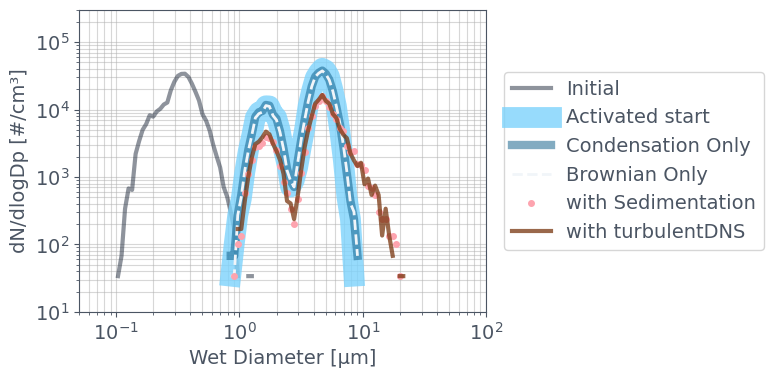

In [6]:
# 1. Create figure & axes
fig, ax = plt.subplots(figsize=(8, 4))

# 2. Extract & clean data for each case
centers_init, dnd_init = distributions["Initial"]
dnd_init = np.where(dnd_init == 0, np.nan, dnd_init)

centers_start, dnd_start = distributions["Start"]
dnd_start = np.where(dnd_start == 0, np.nan, dnd_start)

centers_cond, dnd_cond = distributions["CondensationOnly"]
dnd_cond = np.where(dnd_cond == 0, np.nan, dnd_cond)

centers_brown, dnd_brown = distributions["Brownian"]
dnd_brown = np.where(dnd_brown == 0, np.nan, dnd_brown)

centers_sed, dnd_sed = distributions["Brownian+Sed"]
dnd_sed = np.where(dnd_sed == 0, np.nan, dnd_sed)

centers_turb, dnd_turb = distributions["Brownian+TurbulentDNS"]
dnd_turb = np.where(dnd_turb == 0, np.nan, dnd_turb)

# 3. Plot each line explicitly
ax.plot(
    centers_init,
    dnd_init,
    linewidth=3,
    alpha=0.5,
    color=TAILWIND["slate"]["800"],
    label="Initial",
)

ax.plot(
    centers_start,
    dnd_start,
    linewidth=15,
    alpha=0.8,
    color=TAILWIND["sky"]["300"],
    label="Activated start",
)

ax.plot(
    centers_cond,
    dnd_cond,
    linewidth=6,
    alpha=0.5,
    color=TAILWIND["sky"]["800"],
    label="Condensation Only",
)

ax.plot(
    centers_brown,
    dnd_brown,
    linewidth=2,
    linestyle="--",
    color=TAILWIND["slate"]["100"],
    label="Brownian Only",
)

ax.plot(
    centers_sed,
    dnd_sed,
    marker="o",
    markersize=4,
    linewidth=5,
    alpha=1,
    color=TAILWIND["rose"]["300"],
    linestyle="",
    label="with Sedimentation",
)

ax.plot(
    centers_turb,
    dnd_turb,
    linewidth=3,
    alpha=0.75,
    color=TAILWIND["amber"]["900"],
    label="with turbulentDNS",
)

# 5. Configure axes, grid, legend, and limits
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.05, 100)
ax.set_ylim(10, 3e5)
ax.set_xlabel("Wet Diameter [µm]")
ax.set_ylabel("dN/dlogDp [#/cm³]")
ax.grid(alpha=0.5, which="both")
ax.legend(
    loc="center left",  # anchor the legend’s “center left” corner
    bbox_to_anchor=(
        1.02,
        0.5,
    ),  # (x, y) in axes coordinates: x=1.02 is just past the right edge
    borderaxespad=0.5,  # padding between axes and legend
)
plt.tight_layout()
plt.show()

#### Interpretation of Final Size Distributions

- **Initial (gray)**  
  The dry aerosol starts as a sub‑micron population, peaking around 0.1–0.2 µm—reflecting the log‑normal organic and soot modes before any growth.

- **Activated Start (blue band)**  
  Once exposed to supersaturation, particles grow rapidly into two droplet modes: a smaller mode near 1.8 µm and a larger mode near 5 µm.

- **Condensation Only (dark blue)**  
  Pure vapor condensation leads to little change in the size distribution. The first mode remains nearly unchanged, indicating that it was well equilibrated with the water vapor. The second mode, however, grows slightly larger and broader.

- **Brownian Coagulation (dashed pale line)**  
  Adding only Brownian collisions barely alters the overall shape—slight smoothing of the peaks indicates a few particle pairs merging, but number concentration remains nearly unchanged.

- **Brownian + Sedimentation (pink dots)**  
  Including gravitational settling removes the largest droplets most efficiently, lowering the second‐mode concentration more than the first and slightly skewing the distribution toward larger diameters.

- **Brownian + Turbulent DNS (brown)**  
  Turbulence‑enhanced collisions also broadens the distribution and reduce peak concentrations, especially for the larger droplets, illustrating how combined Brownian, and turbulent (with sedimentation) effects accelerate coagulation and deplete droplet counts at the largest sizes.


### Graph Organic Mass Fraction vs. Wet Diameter

Here we compare each particle’s organic mass fraction before and after the turbulent DNS coagulation:

1. **Extract species masses**  
   - Get the final species‐mass array from the “Brownian+TurbulentDNS” result and the initial aerosol.  
   - Zero out the water column so fractions are computed from organics + soot only.

2. **Compute per‑particle organic fraction**  
   - f_org = m_organics ∕ (m_organics + m_soot)
   - Apply a mask to exclude any zero‑radius particles.

1. **Convert to wet diameters**  
   Use `get_wet_diameters(...)` to obtain each particle’s diameter in µm.

2. **Scatter plot**  
   - **After DNS** (amber, semi‑transparent): shows how turbulence‐enhanced coagulation shifts organic fraction across sizes.  
   - **Initial** (slate, very faint): baseline before any coagulation.


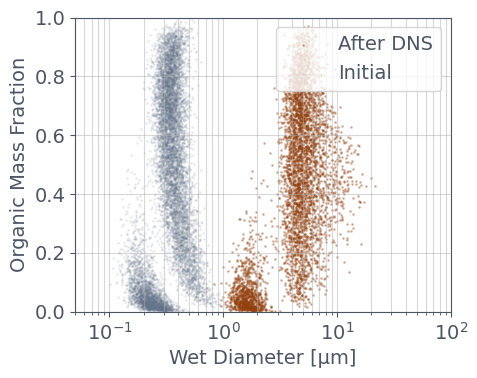

In [7]:
#  1. Retrieve and prepare mass arrays
combined_dns_mass = results[
    "Brownian+TurbulentDNS"
].particles.get_species_mass(clone=True)
initial_mass = aerosol.particles.get_species_mass(clone=True)

mask = results["Brownian+TurbulentDNS"].particles.get_radius() > 0
combined_dns_mass[:, -1] = 0.0  # drop water
initial_mass[:, -1] = 0.0

dns_mass_fraction = combined_dns_mass[mask, 0] / combined_dns_mass[mask].sum(
    axis=1
)
initial_mass_fraction = initial_mass[:, 0] / initial_mass.sum(axis=1)

# 2. Compute wet diameters
dns_dp = get_wet_diameters(results["Brownian+TurbulentDNS"])
initial_dp = get_wet_diameters(aerosol)

# 3. Plot scatter
fig, ax = plt.subplots(figsize=(5, 4))

ax.scatter(
    dns_dp,
    dns_mass_fraction,
    s=1,
    alpha=0.3,
    color=TAILWIND["amber"]["800"],
    label="After DNS",
)
ax.scatter(
    initial_dp,
    initial_mass_fraction,
    s=1,
    alpha=0.1,
    color=TAILWIND["slate"]["500"],
    label="Initial",
)

# 4. Aesthetics
ax.set_xscale("log")
ax.set_xlim(0.05, 100)
ax.set_ylim(0, 1.0)
ax.set_xlabel("Wet Diameter [µm]")
ax.set_ylabel("Organic Mass Fraction")
ax.grid(alpha=0.5, which="both")
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()

#### Impact of Turbulent DNS on Size–Composition Space

This scatter plot shows each particle’s organic mass fraction versus wet diameter **before** (brown) and **after** (blue) applying the Turbulent DNS coagulation sequence.

**What this tells us:**  
Turbulence‑enhanced coagulation preferentially drives mixed droplets to collide and merge into a narrower, organic‑rich population, while leaving a distinct soot‑rich mode of small particles. In other words, turbulent DNS “sorts” particles by both size and composition. The largest mixed droplets then concentrate organics into a tighter size band.  


## Take‑Home Messages

- **End‑to‑End Workflow:**  
  We walked through a complete Particula pipeline—from defining species properties and gas/particle builders, to running time‑resolved condensation and four coagulation scenarios—culminating in clear visualizations of size distributions and mass fractions.

- **Key Insights:**  
  - **Condensation Only** produces the highest droplet peaks, since no particles are lost to collisions.  
  - **Brownian Coagulation** alone has a minimal smoothing effect on the bimodal droplet distribution.  
  - **Sedimentation** preferentially coagulates larger droplets, with smaller. On this time scale and droplet size the effect is similar to Turbulent DNS.  
  - **Turbulent DNS** Broadens the size spectrum and grows large‐diameter droplets, illustrating the combined importance of Brownian, gravitational, and turbulent collisions.

- **Particle‐Resolved Mass Analysis:**  
  By plotting per‑particle organic mass fraction vs. wet diameter, we saw how turbulent coagulation alters composition across size bins—an approach you can adapt to other species or processes.

- **Extensibility:**  
  This modular, object‑oriented approach can be extended to:  
  - Other dynamic processes (e.g., activation kinetics, heterogeneous chemistry)  
  - Different aerosol types and multicomponent mixtures  
  - Automated code lookup and suggestion via an LLM‑backed vector store  

> **Bottom Line:** Particula makes it straightforward to prototype complex aerosol–cloud interactions, compare physical mechanisms quantitatively, and extract particle‐resolved insights—all within a few hundred lines of Python.  
